<a href="https://colab.research.google.com/github/21Ovi/NoteVision/blob/main/NoteVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Welcome to **NoteVision**, a project aimed at converting handwritten notes into digital text using machine learning techniques. This notebook will guide you through the entire process of building a handwriting recognition model using TensorFlow and Python. The dataset used in this project is sourced from Kaggle, consisting of over 400,000 handwritten names.

### Notebook Overview:
1. **Data Preprocessing**: We begin by loading and preparing the dataset, including image normalization and label encoding.
2. **Model Building**: A deep learning model is constructed using TensorFlow, optimized for recognizing handwritten text.
3. **Training & Validation**: The model is trained on the dataset and validated for accuracy using Google Colab's GPU resources.
4. **Evaluation**: Performance metrics and insights are gathered to assess the effectiveness of the model.
5. **Final Model**: The final trained model is saved and ready for deployment.

This notebook provides a step-by-step process for building a handwriting recognition system, complete with explanations and code snippets. Feel free to explore and modify it according to your needs!


## All Imports

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

## Loading Dataset from Google Drive

In [7]:
# Unzip the dataset to a folder in Colab
!unzip -q /content/drive/MyDrive/datasets/archive.zip -d /content/data

replace /content/data/test_v2/test/TEST_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/test_v2/test/TEST_0002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
A


In [8]:
!ls /content/data

test_v2   validation_v2		    written_name_train_v2.csv
train_v2  written_name_test_v2.csv  written_name_validation_v2.csv


## Load and view data

In [9]:
# Load the CSV files using the correct paths
train = pd.read_csv('/content/data/written_name_train_v2.csv')
valid = pd.read_csv('/content/data/written_name_validation_v2.csv')
test = pd.read_csv('/content/data/written_name_test_v2.csv')

# Display the first few rows of each dataset to verify
print("Train Data:")
print(train.head())
print("\nValidation Data:")
print(valid.head())
print("\nTest Data:")
print(test.head())


Train Data:
          FILENAME   IDENTITY
0  TRAIN_00001.jpg  BALTHAZAR
1  TRAIN_00002.jpg      SIMON
2  TRAIN_00003.jpg      BENES
3  TRAIN_00004.jpg    LA LOVE
4  TRAIN_00005.jpg     DAPHNE

Validation Data:
              FILENAME    IDENTITY
0  VALIDATION_0001.jpg       BILEL
1  VALIDATION_0002.jpg  LAUMIONIER
2  VALIDATION_0003.jpg         LEA
3  VALIDATION_0004.jpg   JEAN-ROCH
4  VALIDATION_0005.jpg        RUPP

Test Data:
        FILENAME  IDENTITY
0  TEST_0001.jpg     KEVIN
1  TEST_0002.jpg  CLOTAIRE
2  TEST_0003.jpg      LENA
3  TEST_0004.jpg     JULES
4  TEST_0005.jpg   CHERPIN


### View data

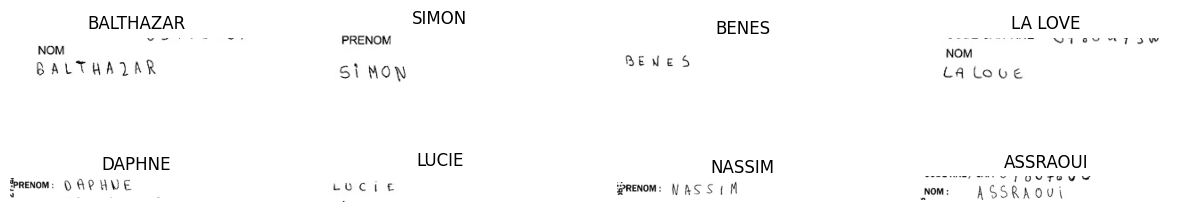

In [10]:
plt.figure(figsize=(15, 10))

for i in range(8):
  ax = plt.subplot(2, 4, i+1)
  # Updated image path to include the additional 'train' folder
  img_dir = '/content/data/train_v2/train/' + train.loc[i, 'FILENAME']
  image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

  # Check if the image was loaded properly
  if image is None:
    print(f"Image not found or failed to load: {img_dir}")
    continue

  plt.imshow(image, cmap='gray')
  plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
  plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)


In [11]:
train_size = len(train)
print(f"Number of samples in the training set: {train_size}")

valid_size = len(valid)
print(f"Number of samples in the validation set: {valid_size}")

test_size = len(test)
print(f"Number of samples in the testing set: {test_size}")

Number of samples in the training set: 330961
Number of samples in the validation set: 41370
Number of samples in the testing set: 41370


## Cleaning Data

In [12]:
print("Number of NaNs in train set       :", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set: :", valid['IDENTITY'].isnull().sum())
print("Number of NaNs in test set        :", test['IDENTITY'].isnull().sum())

Number of NaNs in train set       : 565
Number of NaNs in validation set: : 78
Number of NaNs in test set        : 70


In [13]:
train.dropna(inplace=True)
valid.dropna(inplace=True)

Also, there are some images in this dataset with the label of `UNREADABLE`, we need to get rid of them in order to clean data.

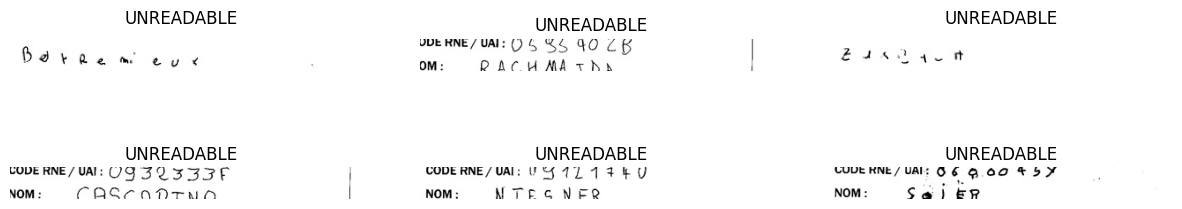

In [14]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace=True, drop=True)

plt.figure(figsize=(15, 10))
for i in range(6):
  ax = plt.subplot(2, 3, i+1)
  img_dir = '/content/data/train_v2/train/' + unreadable.loc[i, 'FILENAME']
  image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
  plt.imshow(image, cmap='gray')
  plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
  plt.axis('off')

  plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [15]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [16]:
train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)

In [17]:
train_size = len(train)
print(f"Number of samples in the training set: {train_size}")

valid_size = len(valid)
print(f"Number of samples in the validation set: {valid_size}")

test_size = len(test)
print(f"Number of samples in the testing set: {test_size}")

Number of samples in the training set: 330294
Number of samples in the validation set: 41280
Number of samples in the testing set: 41370


## Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y).
* The image is then normalized to range [0, 1]

In [18]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

The model will be trained on 30000 images and validate on 3000 images



In [19]:
train_size = 30000
valid_size= 3000

In [20]:
train_x = []

for i in range(train_size):
    img_dir = '/content/data/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [21]:
valid_x = []

for i in range(valid_size):
    img_dir = '/content/data/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [22]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [23]:
print(f"Shape of preprocessed training data: {train_x.shape}")  # First value is the number of samples
print(f"Shape of preprocessed validation data: {valid_x.shape}")
# Assuming test data is preprocessed similarly as train_x and valid_x
# print(f"Shape of preprocessed testing data: {test_x.shape}")

Shape of preprocessed training data: (30000, 256, 64, 1)
Shape of preprocessed validation data: (3000, 256, 64, 1)


### Preparing the labels for CTC Loss

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (- ' and space).


In [24]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [25]:
name = 'OVESH'
print(name, '\n',label_to_num(name))

OVESH 
 [14 21  4 18  7]




*  `train_y` contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len.
*  `train_label_len` contains the length of each true label (without padding)
* `train_input_len` contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.
* `train_output` is a dummy output for ctc loss.







Number of labels longer than 24 characters: 1
Percentage of long labels in training set: 0.00%


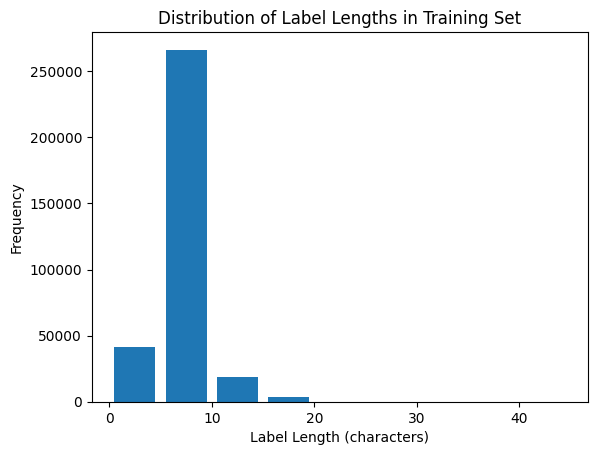

In [26]:
# Deffine the threshold for a "long" label
threshold = 24

# Calculate the length of eachj label in the training set
train['label_length'] = train['IDENTITY'].apply(len)


# Find labels longer than the threshold
long_labels = train[train['label_length'] > threshold]

# Count how many labels are longer than the threshold
num_long_labels = len(long_labels)

# Calculate the percentage of long labels in the dataset
percentage_long_labels = (num_long_labels / len(train)) * 100

print(f"Number of labels longer than {threshold} characters: {num_long_labels}")
print(f"Percentage of long labels in training set: {percentage_long_labels:.2f}%")

# Optional: Plot a histogram of label lengths
train['label_length'].plot(kind='hist', bins=range(0, 50, 5), rwidth=0.8)
plt.title('Distribution of Label Lengths in Training Set')
plt.xlabel('Label Length (characters)')
plt.ylabel('Frequency')
plt.show()


In [27]:
# Apply the same steps to the validation set
valid['label_length'] = valid['IDENTITY'].apply(len)
long_labels_valid = valid[valid["label_length"] > threshold]
num_long_labels_valid = len(long_labels_valid)
percentage_long_labels_valid = (num_long_labels_valid / len(valid)) * 100

print(f"Number of labels longer than {threshold} characters in the validation set: {num_long_labels_valid}")
print(f"Percentage of long label in validation set: {percentage_long_labels_valid:.2f}%")

Number of labels longer than 24 characters in the validation set: 0
Percentage of long label in validation set: 0.00%


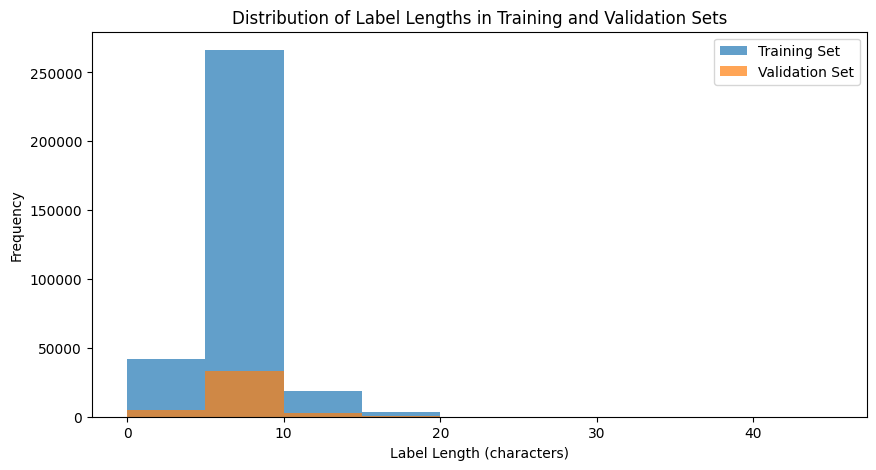

In [28]:
# Plot histogram for both train and validation sets
plt.figure(figsize=(10, 5))

# Training set
plt.hist(train['label_length'], bins=range(0, 50, 5), alpha=0.7, label='Training Set')
# Validation set
plt.hist(valid['label_length'], bins=range(0, 50, 5), alpha=0.7, label='Validation Set')

plt.title('Distribution of Label Lengths in Training and Validation Sets')
plt.xlabel('Label Length (characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [29]:
# Remove rows with label length greater than 24 characters in-place
train = train[train['label_length'] <= 24]

# Reset index after filtering
train.reset_index(drop=True, inplace=True)

print(f"Modified training set size: {len(train)}")

Modified training set size: 330293


In [30]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [31]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [32]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100],
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


## Building our model

In [ ]:
# Combine training and validation data
combined_x = np.concatenate((train_x, valid_x), axis=0)
combined_y = np.concatenate((train_y, valid_y), axis=0)

# Assuming train_label_len and valid_label_len are also combined
combined_label_len = np.concatenate((train_label_len, valid_label_len), axis=0)
combined_input_len = np.concatenate((train_input_len, valid_input_len), axis=0)

# Split the combined dataset into training and validation sets
train_X, valid_X, train_Y, valid_Y, train_input_len, valid_input_len, train_label_len, valid_label_len = train_test_split(
    combined_x,
    combined_y,
    combined_input_len,
    combined_label_len,
    test_size=0.0909,  # Adjust the split ratio as needed
    random_state=42
)